## CarND Vehicle Detection


Auxiliary functions



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

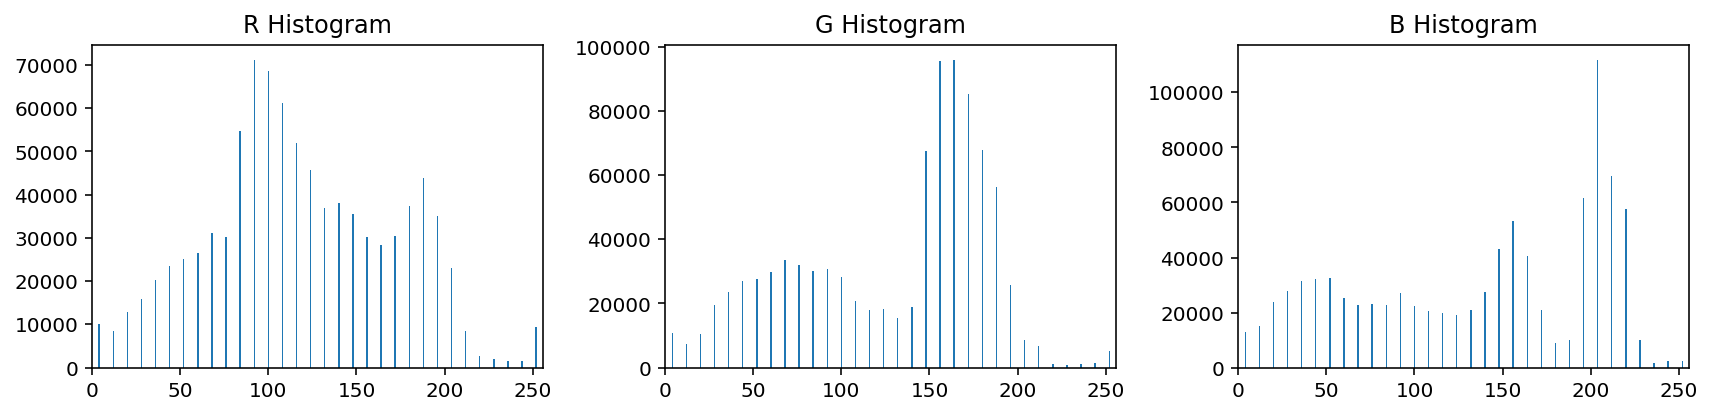

In [3]:

image = mpimg.imread('../test_images/test1.jpg')

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
    ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
    bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

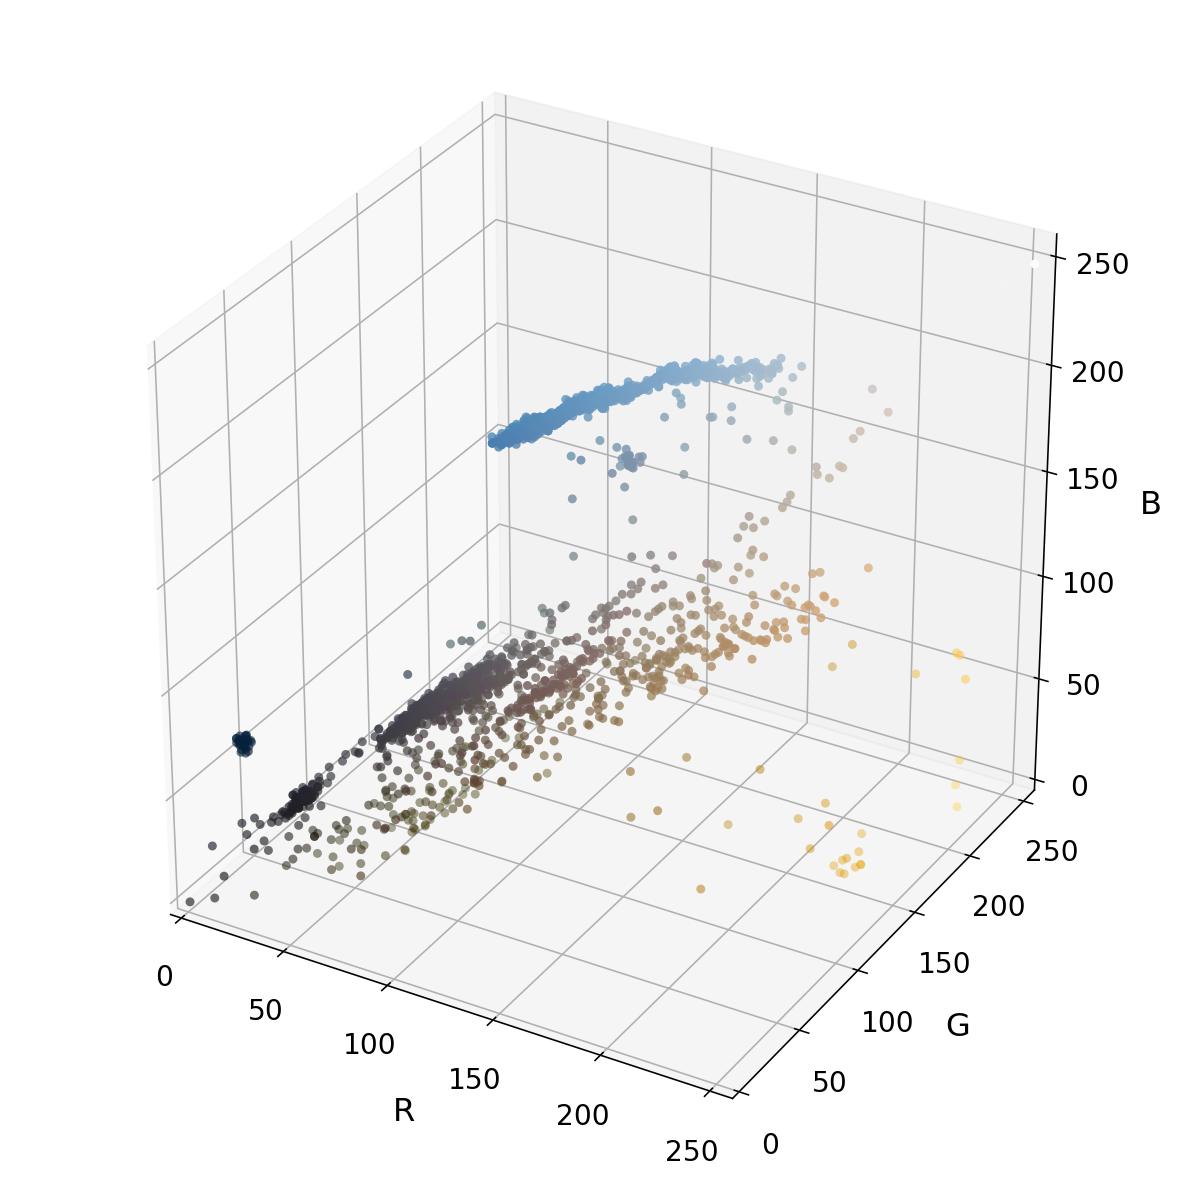

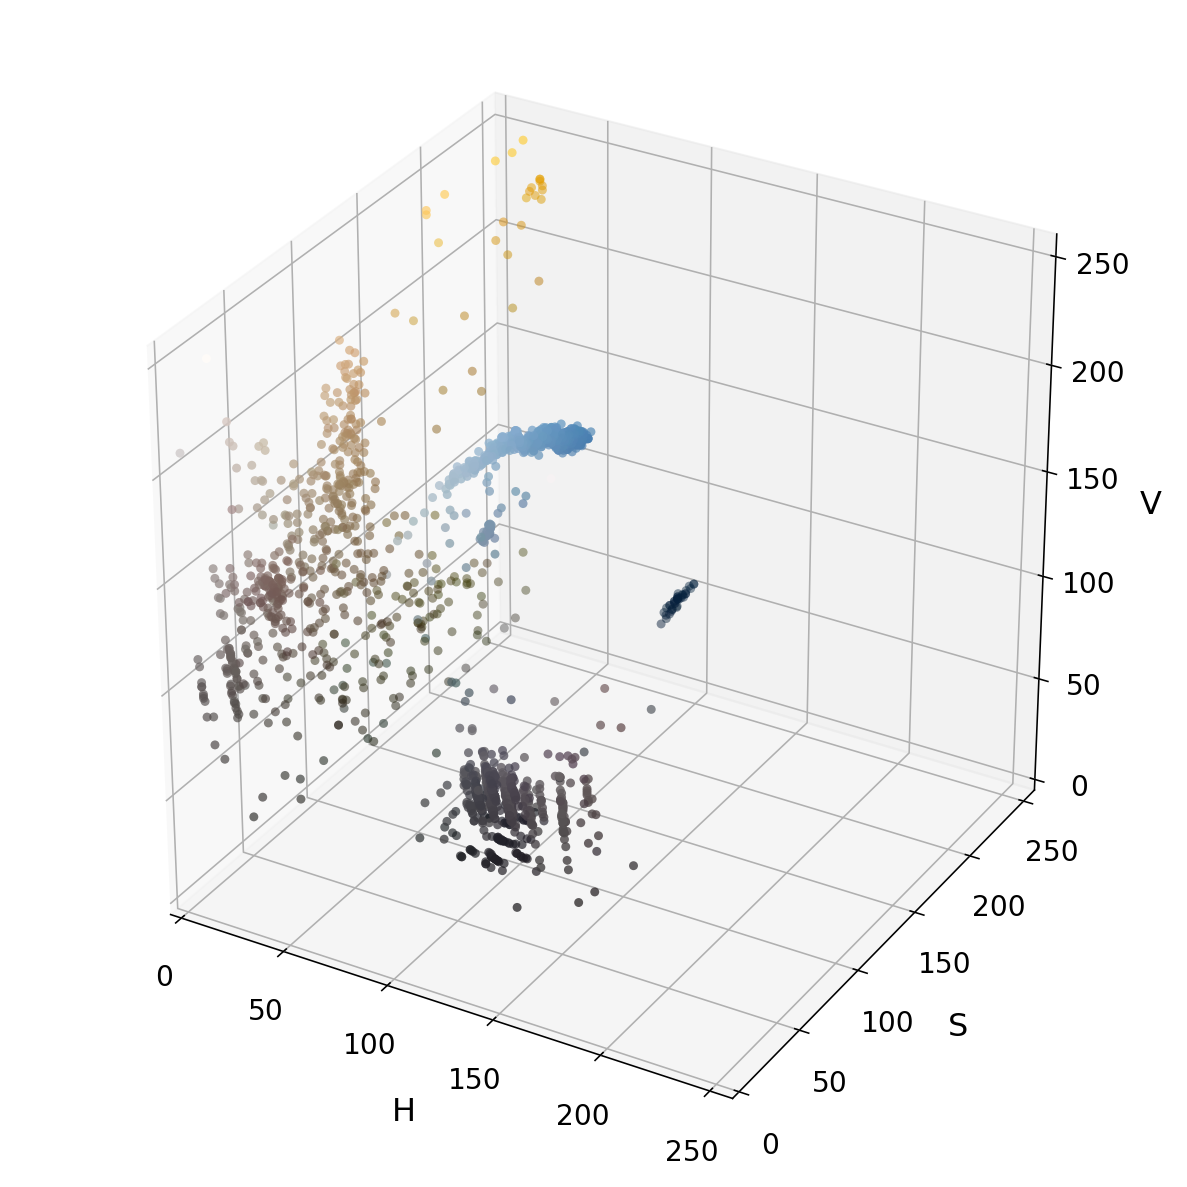

In [5]:
#Plot 3D 

from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = cv2.imread('../test_images/test2.jpg')

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

plt.figure(figsize=(5,5))
# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()


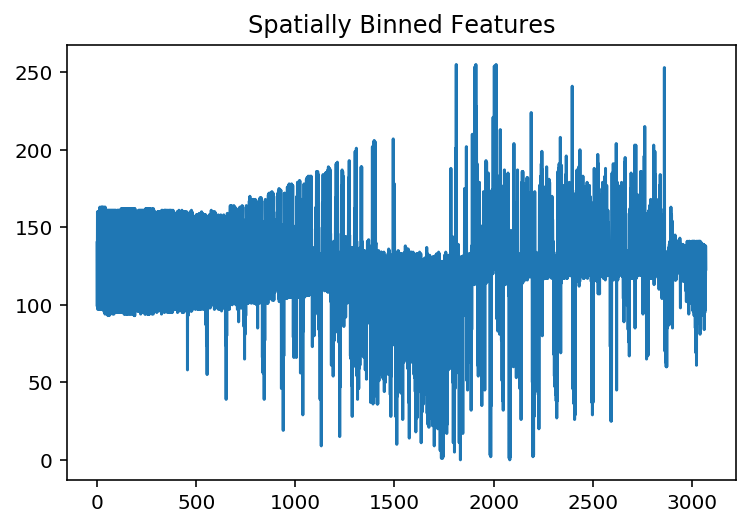

In [6]:
#Spatial bin of an image
# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = mpimg.imread('../test_images/test1.jpg')

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    
    return features
    

feature_vec = bin_spatial(image, color_space='YCrCb', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

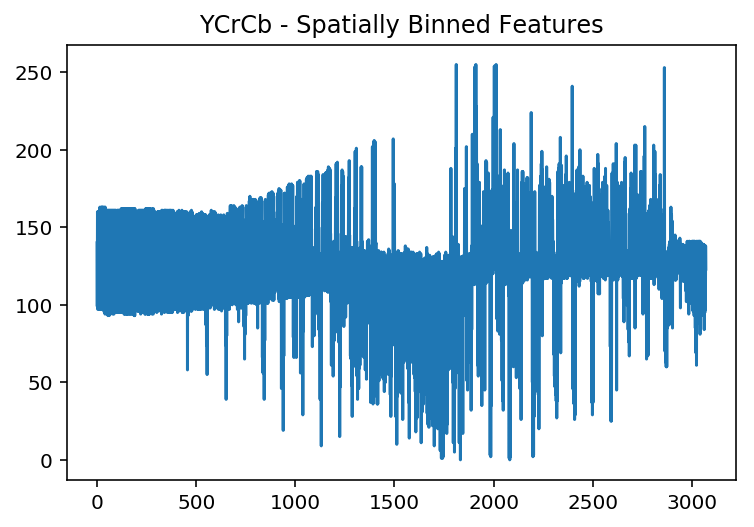

In [7]:
# Plot features
def fBIN(color_s):
    feature_vec = bin_spatial(image, color_space=color_s, size=(32, 32))
    plt.plot(feature_vec)
    plt.title(color_s + ' - Spatially Binned Features')
    

interact(fBIN, color_s={'HSV':'HSV', 'LUV':'LUV','HLS':'HLS','YUV':'YUV','YCrCb':'YCrCb'});



In [8]:
# images are divided up into vehicles and non-vehicles
import fnmatch
import os

images = []
# for root, dirnames, filenames in os.walk('../dataset-big'):
#     for filename in fnmatch.filter(filenames, '*.png'):
for root, dirnames, filenames in os.walk('../dataset-small'):
    for filename in fnmatch.filter(filenames, '*.jpeg'):
        images.append(os.path.join(root, filename))
# images

cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
# cars

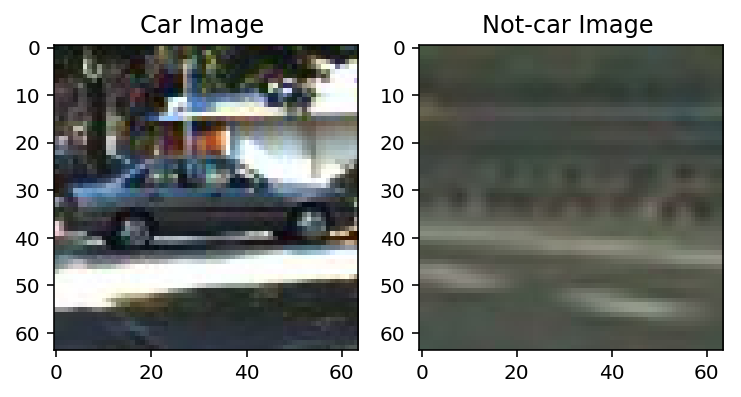

In [9]:
#Two examples 

car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


plt.subplot(1,2,1)
plt.imshow(car_image)
plt.title('Car Image ')
plt.subplot(1,2,2)
plt.imshow(notcar_image)
plt.title('Not-car Image ')


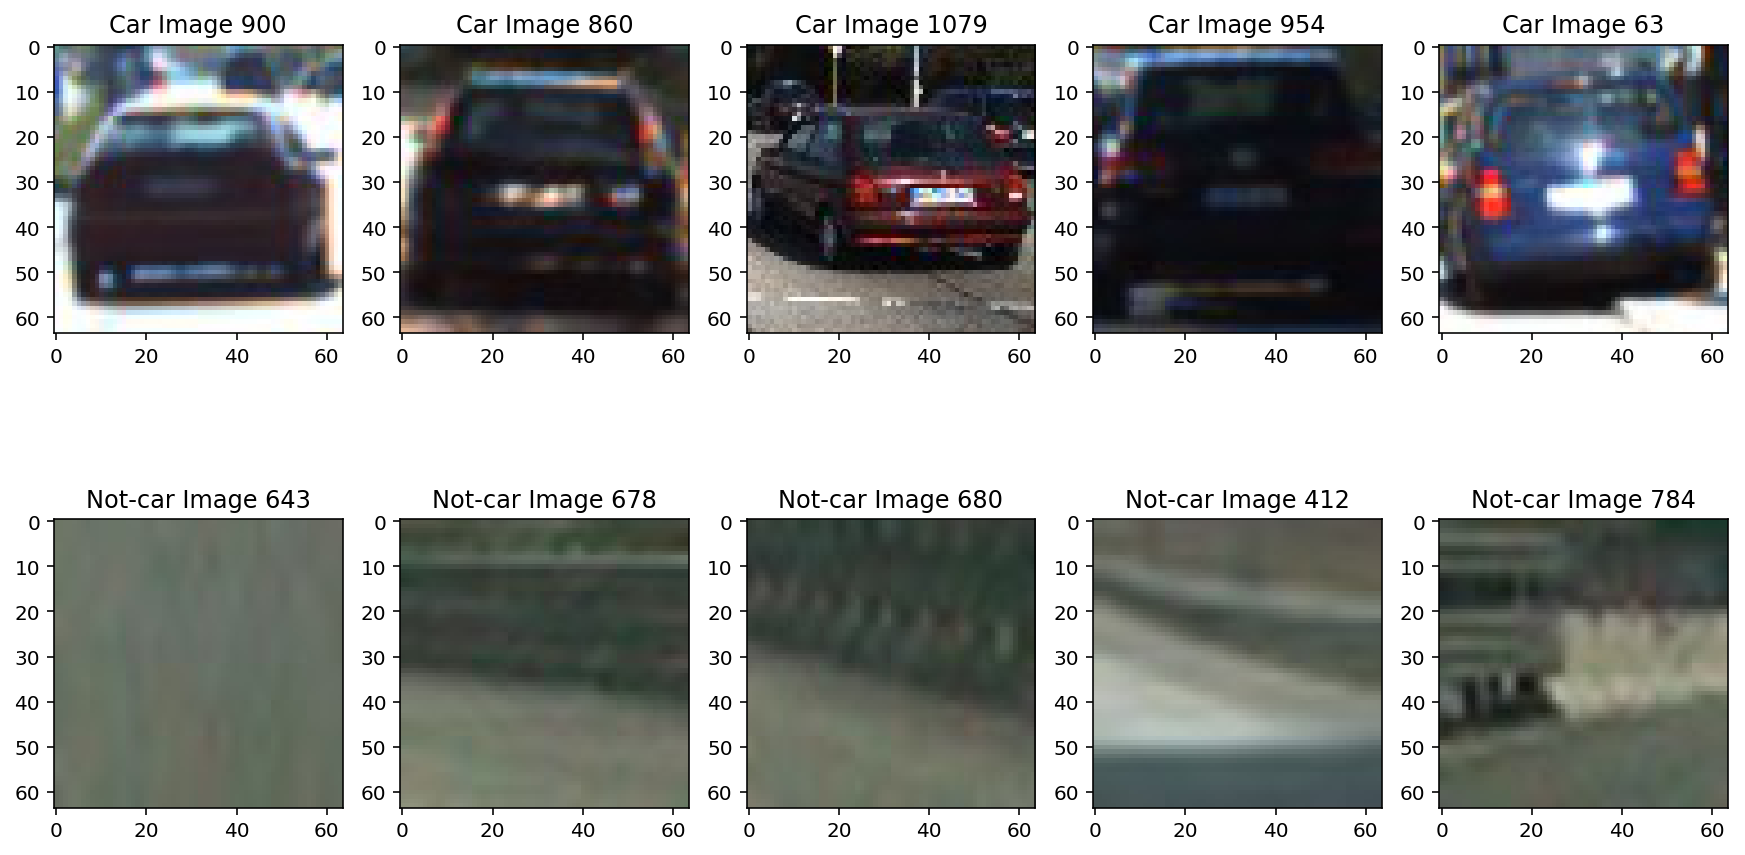

In [10]:
# Plot examples

def plotExamples():
    plt.figure(figsize=(15,8))

    for i in range(5):
        car_ind = np.random.randint(0, len(cars))
        notcar_ind = np.random.randint(0, len(notcars))

        # Read in car / not-car images
        car_image = mpimg.imread(cars[car_ind])
        notcar_image = mpimg.imread(notcars[notcar_ind])


        plt.subplot(2,5,i+1)
        plt.imshow(car_image)
        plt.title('Car Image ' + str(car_ind))
        plt.subplot(2,5,5+i+1)
        plt.imshow(notcar_image)
        plt.title('Not-car Image ' + str(notcar_ind))

interact_manual(plotExamples)

In [11]:
#Data augmentation not need, because seems to already have some, and hog is robust

#Number of samples
n_cars = len(cars)
n_notcars = len(notcars)

print("n_cars: ",n_cars)
print("n_notcars: ",n_notcars)

n_cars:  1196
n_notcars:  1125


In [12]:
#Test with HOG
from skimage.feature import hog

def get_hog_features(image, cspace='RGB', orient=8, pix_per_cell=(8,8), cell_per_block=(2,2), hog_channel=0, vis=False, feat_vec=True):
    if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    else: 
        feature_image = np.copy(image)
    
    if hog_channel<3:
        img = feature_image[:,:,hog_channel]
    else:
        img = np.copy(feature_image)
    
    #print('feature_image.shape', feature_image.shape)  
    #print('img.shape',img.shape)  
    
    
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=pix_per_cell, cells_per_block=cell_per_block, visualise=vis, transform_sqrt=False, feature_vector=feat_vec, normalise=None)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=pix_per_cell, cells_per_block=cell_per_block, visualise=vis, transform_sqrt=False, feature_vector=feat_vec, normalise=None)
        return features
    


In [16]:

def get_hog_interact(image, cspace, orient =8, npixpercells =8, cellsperblock = 1,hog_channel=0, vis=True, feat_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = get_hog_features(image, cspace, orient, (npixpercells,npixpercells), (cellsperblock,cellsperblock), hog_channel, vis, feat_vec)
        #plt.imshow(hog_image)
        plt.figure(figsize=(10,10))
        plt.subplot(121)
        #plt.imshow(img,cmap='gray')
        #plt.subplot(122)
        plt.imshow(hog_image, cmap = 'gray')
    else:      
        features = get_hog_features(image, cspace, orient, (pix_per_cell,pix_per_cell), (cell_per_block,cell_per_block), hog_channel, vis, feat_vec)
        #return features



In [22]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
img =mpimg.imread(cars[car_ind])
#img = mpimg.imread(notcars[notcar_ind])


<function __main__.get_hog_interact>

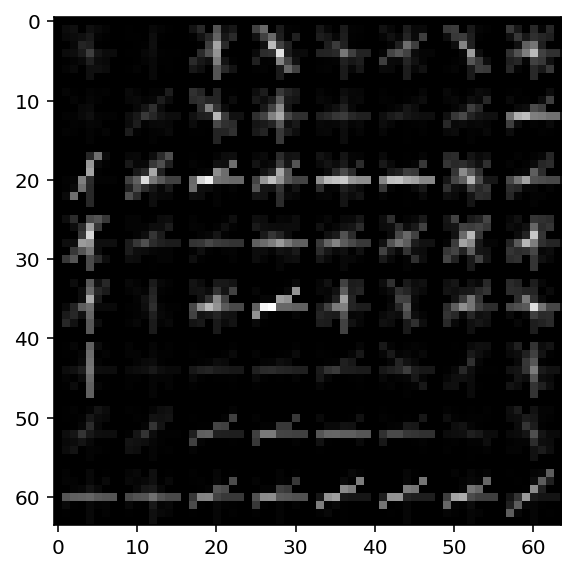

In [23]:
#img = mpimg.imread('image0038.png')

interact(get_hog_interact, image=fixed(img),cspace={'RGB':'RGB','HSV':'HSV', 'LUV':'LUV','HLS':'HLS','YUV':'YUV','YCrCb':'YCrCb'},orient=(1,16), npixpercells =(1,16), cellsperblock =(1,8),hog_channel=(0,3), vis=fixed(True), feat_vec=fixed(True))

#Final parameters
#orient = 8
#npixpercells =8
#cellsperblock =2
#HSV channel 2

In [24]:
#Plot each channel separated

def plotChannels(image, cspace ='RBG'):
    if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image)
    
    fig = plt.figure(figsize=(20,10))

    plt.subplot(3,1,1)
    plt.imshow(feature_image[:,:,0],cmap = 'gray')
    plt.subplot(3,1,2)
    plt.imshow(feature_image[:,:,1],cmap = 'gray')
    plt.subplot(3,1,3)
    plt.imshow(feature_image[:,:,2],cmap = 'gray')


<function __main__.plotChannels>

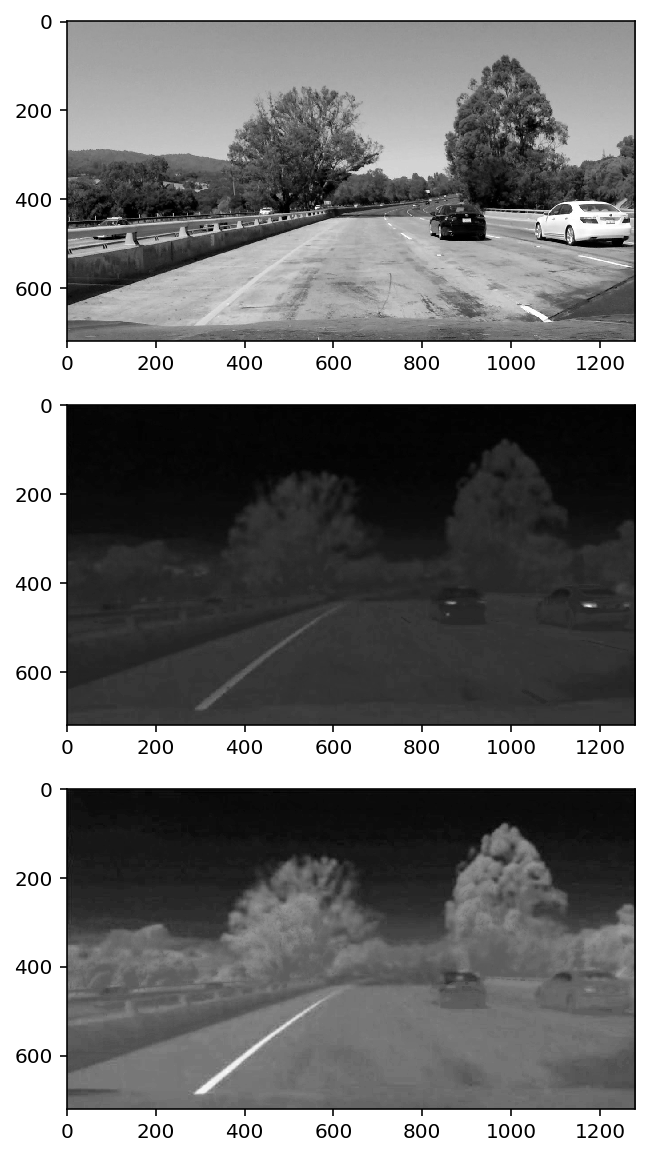

In [26]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))


# Read in car / not-car images
#img =mpimg.imread(cars[car_ind])
#img = mpimg.imread(notcars[notcar_ind])
img =mpimg.imread('../test_images/test1.jpg')

interact(plotChannels, image=fixed(img),cspace={'RGB':'RGB','HSV':'HSV', 'LUV':'LUV','HLS':'HLS','YUV':'YUV','YCrCb':'YCrCb'})
